In [3]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter

# text
import torch
from torchtext.data.utils import get_tokenizer

# rnn stuff
from torch import nn
from torch.nn.utils.rnn import pad_sequence

# basics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import torchinfo

import warnings
warnings.filterwarnings('ignore')

# plotting
!pip install livelossplot
from livelossplot import PlotLosses
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

# Load Data

In [4]:
df = pd.read_csv('/kaggle/input/reviewscores/train.csv')
preprocessed = pd.read_csv('/kaggle/input/reviewscores/preprocessed.csv')

df = df.merge(preprocessed, on = 'review_id')

df['positiveV0'] = [x.lower().strip() for x in df['positive']]
df['negativeV0'] = [x.lower().strip() for x in df['negative']]
df['negative_tokensV0'] = [x.split(' ') for x in df['negativeV0']]
df['negative_tokensV1'] = [x.split(' ') for x in df['negativeV1']]
df['positive_tokensV0'] = [x.split(' ') for x in df['positiveV0']]
df['positive_tokensV1'] = [x.split(' ') for x in df['positiveV1']]

df['score'] = df['score'].astype(np.float32)
df.loc[df['positiveV1'] == 'no positive', 'positiveV1'] = '<no_positive>'

In [5]:
# split into training and validation
df_train, df_val = train_test_split(df, random_state=1412) # <- для локального тестирования
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

# Vocabulary

In [6]:
class Vocabulary:
    def __init__(self, min_count, max_size, max_length):
        self.min_count, self.max_size = min_count, max_size
        self.max_length = max_length
        """
         * <PAD> -- used to match sizes of all sentences in a batch
         * <SOPR> -- start of the positive review
         * <EOPR> -- end of the positive review
         * <SONR> -- start of the negative review 
         * <EONR> -- end of the negative review 
         * <UNK> -- unknown word, not in vocabulary
        """
        self.int_to_str = {0: '<PAD>', 1:'<SOPR>', 2:'<EOPR>',
                           3: '<SONR>', 4: '<EONR>', 5: '<UNK>'}
        self.str_to_int = {str_: int_ for int_, str_ in self.int_to_str.items()}
        self.tokenizer = lambda x : x.split(' ')
        
    def __len__(self):
        return len(self.int_to_str)
    
    def build_vocabulary(self, negative_reviews, positive_reviews):
        idx = 6 # starting index
        
        # mark negative wrds
        negative_wrds = []
        for sentence in negative_reviews:
            negative_wrds.extend(self.tokenizer(sentence))
        negative_wrds = ['NEG_' + x for x in negative_wrds]
        # mark positive wrds
        positive_wrds = []
        for sentence in positive_reviews:
            positive_wrds.extend(self.tokenizer(sentence))
        positive_wrds = ['POS_' + x for x in positive_wrds]
        # combine wrds
        wrds = negative_wrds + positive_wrds
        
        freq_dict = Counter(wrds) 
        
        # 1. account for min_count
        freq_dict = {wrd: freq for wrd, freq in freq_dict.items() if freq > self.min_count} 
        
        # 2. sort and account for max_size
        freq_dict = dict(sorted(freq_dict.items(), key = lambda x: -x[1])[:self.max_size-idx])  
        
        # create vocabulary
        for wrd in freq_dict.keys():
            self.str_to_int[wrd] = idx
            self.int_to_str[idx] = wrd
            idx +=1 
        pass
    
    def text_to_intseq(self, text, review_type):
        tokens = self.tokenizer(text)
        if review_type == 'negative':
            tokens = ['NEG_' + x for x in tokens]
        else:
            tokens = ['POS_' + x for x in tokens]
        int_tokens = [self.str_to_int[token] if token in self.str_to_int.keys() else self.str_to_int['<UNK>'] for token in tokens]
        return int_tokens[:self.max_length]

    def intseq_to_text(self, intseq):
        tokens = [self.int_to_str[x] if x <= self.max_size else '<UNK>' for x in intseq]
        # trim NEG_ and POS_ prefixes
        tokens = [x if '<' in x else x[4:] for x in tokens]
        
        return ' '.join(tokens)

# DataSets

In [7]:
class ReviewsTrain(torch.utils.data.Dataset):
    def __init__(self, df, negative_column, positive_column, target, min_count, max_size,
                 max_length):
        self.df = df
        self.target = np.round(df[target],1) 
        self.min_count, self.max_size = min_count, max_size
        self.max_length = max_length
        
        self.negative_reviews = df[negative_column]
        self.positive_reviews = df[positive_column]
        
        # vocabulary
        self.vocab = Vocabulary(min_count, max_size, max_length)
        self.vocab.build_vocabulary(negative_reviews = self.negative_reviews.tolist(),
                                    positive_reviews = self.positive_reviews.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        negative_review = self.negative_reviews[index]
        positive_review = self.positive_reviews[index]
        
        # start of positive review
        intseq = [self.vocab.str_to_int["<SOPR>"]]
        intseq += self.vocab.text_to_intseq(positive_review, 
                                                     review_type='positive')
        intseq.append(self.vocab.str_to_int["<EOPR>"])

        # start of negative review
        intseq.append(self.vocab.str_to_int["<SONR>"])
        intseq += self.vocab.text_to_intseq(negative_review,
                                                     review_type='negative')
        intseq.append(self.vocab.str_to_int["<EONR>"])
        
        return torch.tensor(intseq), torch.tensor(self.target[index])

In [8]:
class ReviewsValidation(torch.utils.data.Dataset):
    def __init__(self, train_dataset, df, negative_column, positive_column, target):
                
        self.df = df
        
        self.target = df[target]
        self.negative_reviews = df[negative_column]
        self.positive_reviews = df[positive_column]

        self.train_dataset = train_dataset
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        negative_review = self.negative_reviews[index]
        positive_review = self.positive_reviews[index]
        
        # start of positive review
        intseq = [self.train_dataset.vocab.str_to_int["<SOPR>"]]
        intseq += self.train_dataset.vocab.text_to_intseq(positive_review, 
                                                          review_type = 'positive')
        intseq.append(self.train_dataset.vocab.str_to_int["<EOPR>"])

        # start of negative review
        intseq.append(self.train_dataset.vocab.str_to_int["<SONR>"])
        intseq += self.train_dataset.vocab.text_to_intseq(negative_review,
                                                         review_type = 'negative')
        intseq.append(self.train_dataset.vocab.str_to_int["<EONR>"])
                
        return torch.tensor(intseq), torch.tensor(self.target[index])

# DataLoaders

In [9]:
class CollateFN:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        features = [item[0] for item in batch] 
        lengths = torch.tensor([len(item[0]) for item in batch])
        features = pad_sequence(features, batch_first = True, padding_value = self.pad_idx) 
        
        labels = torch.tensor([item[1] for item in batch])
        return features, labels, lengths
    
def get_loader(dataset, batch_size, num_workers=0, shuffle=True, pin_memory=False): 
    pad_idx = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, num_workers = num_workers,
                        shuffle = shuffle, pin_memory = pin_memory, 
                        collate_fn = CollateFN(pad_idx = pad_idx))
    return loader

# Train Function

In [10]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

def train(optimizer, ctiterion, scheduler, model, train_loader, val_loader, epochs, device):
    """
        * currently scheduler does nothing
    """
    liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(8,2)), ExtremaPrinter()])
    model.to(device)
    
    phases = ['train']
    if val_loader:
        phases.append('val')
        
    for epoch in range(epochs):
        logs = {}
        for phase in phases:
            # set phase parameters
            if phase == 'train':
                model.train()
                total_len = len(train_loader)
                loader = train_loader
            else:
                model.eval()
                total_len = len(val_loader)
                loader = val_loader
                
            # reset loss and counter
            running_loss = 0.
            counter = 0
            
            # go through batchs
            with tqdm(total=total_len) as prbar:
                for x, label, lengths in loader:
                    counter += 1
                    out = model(x.to(device), lengths)
                    if phase == 'val':
                        out = torch.clip(out, min = 0, max = 10)
                    loss = criterion(out, label.to(device))
                    if phase == 'train':
                        optimizer.zero_grad()
                        model.zero_grad()
                        loss.backward()
                        optimizer.step()
                    running_loss += loss.item()
                    prbar.set_description(f"[Epoch {epoch+1}/{epochs}] {phase} Loss: {round(loss.item(), 4)} ")
                    prbar.update(1)
            # calculate epoch-wise loss
            running_loss = running_loss/counter
            
            if phase == 'val' and scheduler:
                scheduler.step(running_loss)
            
            # store results in logs
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
                
            logs[prefix + 'loss'] = running_loss
        
        liveloss.update(logs)
        liveloss.send()
    return model

# Optimizer

In [11]:
from torch.optim.optimizer import Optimizer

class Lion(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                      continue

                # Perform stepweight decay
                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                grad = p.grad
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                  # Exponential moving average of gradient values
                  state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']
                beta1, beta2 = group['betas']

                # Weight update
                update = exp_avg * beta1 + grad * (1 - beta1)
                p.add_(torch.sign(update), alpha=-group['lr'])
                # Decay the momentum running average coefficient
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)
        return loss

# Model: CNN + BiLSTM + Dense

In [12]:
class Version1(nn.Module):
    def __init__(self, num_embeddings, embedding_size, kernel_sizes_list, conv_out_size,
                 num_LSTM_layers, hidden_size, batch_size, device):
        super(Version1, self).__init__()
        
        # parameters
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        self.kernel_sizes_list = kernel_sizes_list
        self.conv_out_size = conv_out_size
        self.num_LSTM_layers = num_LSTM_layers
        self.hidden_size = hidden_size
        self.output_size = 1
        self.batch_size = batch_size
        self.device = device
        
        # Embedding
        self.embedding = nn.Embedding(num_embeddings, embedding_size).to(device)
        
        # layer normalization
        self.layer_norm = nn.LayerNorm(embedding_size).to(device)
        
        # Convolution Layers
        self.cnns = nn.ModuleList([nn.Conv1d(in_channels=embedding_size, out_channels = conv_out_size, 
                                             kernel_size=k).to(device) for k in kernel_sizes_list])
        
        # LSTM
        self.lstm_layer = nn.LSTM(input_size = conv_out_size, 
                                  hidden_size = hidden_size, 
                                  batch_first=True, num_layers = num_LSTM_layers, bias=True, 
                                  bidirectional = True,
                                  dropout = 0.5).to(device)
        
        self.layer_norm_lstm = nn.LayerNorm(2*hidden_size).to(device)
        # Relu
        self.relu = nn.LeakyReLU()
        # Dropout
        self.dropout = nn.Dropout(p=0.0)
        # Fully Connected 1
        self.fc1 = nn.Linear(2*hidden_size, hidden_size).to(device)
        # Fully Connected 2
        self.fc2 = nn.Linear(hidden_size, self.output_size).to(device)
        
        
    def forward(self, x, lengths):
        # 0. Initiate hidden
        """
        Note that we do not pass hidden layer between batches, but we can do so
        """
        (h0, c0) = self.init_hidden()
        # 1. Embedding + Layer Normalization
        embed_out = self.layer_norm(self.embedding(x))
        # 2. CNN
        embed_out = embed_out.permute(0,2,1)
        cnn_outs = []
        for conv in self.cnns:
            f = self.conv_and_max_pool(embed_out,conv)
            cnn_outs.append(f)
        cnn_out = torch.cat(cnn_outs, dim=1).to(self.device)
        packed_cnn_out = nn.utils.rnn.pack_padded_sequence(cnn_out, lengths.cpu().numpy(), 
                                                     batch_first=True, 
                                                     enforce_sorted=False).to(self.device)
        # 2. Packing
        # 3. LSTM
        lstm_out, (h_out, c_out) = self.lstm_layer(packed_cnn_out, (h0, c0))
        # 5. last hidden layers + normalization
        x = self.layer_norm_lstm(torch.cat([h_out[-2], h_out[-1]], dim=1))
        # 6. ReLU + FC + dropout
        x = self.fc1(self.relu(self.dropout(x)))
        x = self.fc2(self.relu(x)).squeeze()
        return x
    
    @staticmethod
    def conv_and_max_pool(x, conv):
        """Convolution and global max pooling layer"""
        return torch.nn.functional.max_pool1d(torch.nn.functional.elu(conv(x)),1).permute(0, 2, 1)
    
    def init_hidden(self):
        h0 = torch.zeros(2*self.num_LSTM_layers, self.batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(2*self.num_LSTM_layers, self.batch_size, self.hidden_size).to(self.device)
        return (h0, c0)

# Training

In [44]:
# build datasets
ds_train = ReviewsTrain(df_train, negative_column = 'negativeV1', 
                        positive_column = 'positiveV1', target = 'score', 
                        min_count = 3, max_size = 99999, max_length = 128)
ds_val = ReviewsValidation(ds_train, df_val, negative_column = 'negativeV1', 
                           positive_column = 'positiveV1', target = 'score')


In [68]:
# define model
BATCH_SIZE     = 256
EMBEDDING_SIZE = 128
KERNEL_SIZES_LIST = [3, 5]
CONV_OUT_SIZE = 32
NUM_LSTM_LAYERS= 2
HIDDEN_SIZE    = 64
DEVICE         = 'cuda:0'
EPOCHS         = 5

train_loader = get_loader(ds_train, batch_size = BATCH_SIZE)
val_loader = get_loader(ds_val, batch_size = BATCH_SIZE)

NUM_EMBEDDINGS = len(train_loader.dataset.vocab)

model = Version1(num_embeddings = NUM_EMBEDDINGS, embedding_size = EMBEDDING_SIZE,
                 kernel_sizes_list = KERNEL_SIZES_LIST, conv_out_size = CONV_OUT_SIZE,
                 num_LSTM_layers = NUM_LSTM_LAYERS, hidden_size = HIDDEN_SIZE, device = DEVICE, batch_size = BATCH_SIZE)

# weight initialization
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

scheduler = None
criterion = nn.L1Loss()
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Version1                                 --
├─Embedding: 1-1                         1,310,976
├─LayerNorm: 1-2                         256
├─ModuleList: 1-3                        --
│    └─Conv1d: 2-1                       12,320
│    └─Conv1d: 2-2                       20,512
├─LSTM: 1-4                              149,504
├─LayerNorm: 1-5                         256
├─LeakyReLU: 1-6                         --
├─Dropout: 1-7                           --
├─Linear: 1-8                            8,256
├─Linear: 1-9                            65
Total params: 1,502,145
Trainable params: 1,502,145
Non-trainable params: 0

In [69]:
# x, label, lengths = next(iter(train_loader))
# model(x.to(DEVICE), lengths)

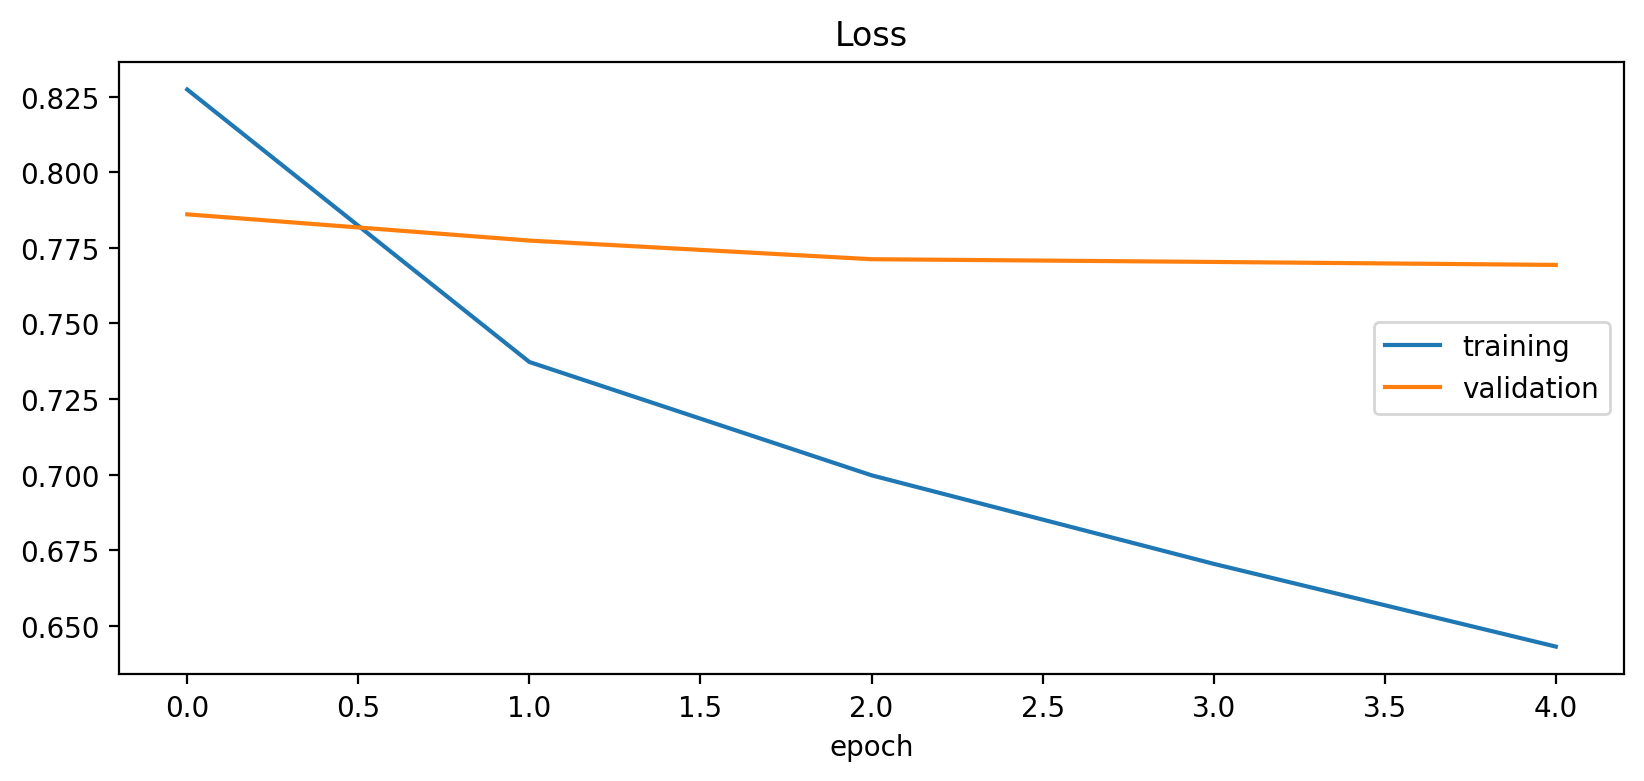

Loss
	training         	 (min:    0.643, max:    0.827, cur:    0.643)
	validation       	 (min:    0.769, max:    0.786, cur:    0.769)


Version1(
  (embedding): Embedding(10242, 128)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (cnns): ModuleList(
    (0): Conv1d(128, 32, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 32, kernel_size=(5,), stride=(1,))
  )
  (lstm_layer): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (layer_norm_lstm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [70]:
# best results: LSTM dropout = 0.5, FC dropout -- 0.0, weight_decay 0.001
# warm up 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
scheduler = None
train(optimizer, criterion, scheduler, model, train_loader, val_loader, epochs = 1, device = DEVICE)

# training
optimizer = Lion(model.parameters(), lr = 0.001, betas=(0.9, 0.98), weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 2, verbose = True)
train(optimizer, criterion, scheduler, model, train_loader, val_loader, epochs = EPOCHS, device = DEVICE)

# Prepare Submission Data

**Full Data for training**

In [13]:
ds_full = ReviewsTrain(df, negative_column = 'negativeV1', 
                        positive_column = 'positiveV1', target = 'score', 
                        min_count = 3, max_size = 99999, max_length = 128)

**Submission Data**

In [14]:
class ReviewsSubmission(torch.utils.data.Dataset):
    def __init__(self, train_dataset, df, negative_column, positive_column, review_id):
                
        self.df = df
        
        self.target = df[review_id]
        self.negative_reviews = df[negative_column]
        self.positive_reviews = df[positive_column]

        self.train_dataset = train_dataset
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        negative_review = self.negative_reviews[index]
        positive_review = self.positive_reviews[index]
        
        # start of positive review
        intseq = [self.train_dataset.vocab.str_to_int["<SOPR>"]]
        intseq += self.train_dataset.vocab.text_to_intseq(positive_review, 
                                                          review_type = 'positive')
        intseq.append(self.train_dataset.vocab.str_to_int["<EOPR>"])

        # start of negative review
        intseq.append(self.train_dataset.vocab.str_to_int["<SONR>"])
        intseq += self.train_dataset.vocab.text_to_intseq(negative_review,
                                                         review_type = 'negative')
        intseq.append(self.train_dataset.vocab.str_to_int["<EONR>"])
                
        return torch.tensor(intseq), self.target[index]
    
class CollateFN_submit:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        features = [item[0] for item in batch] 
        lengths = torch.tensor([len(item[0]) for item in batch])
        features = pad_sequence(features, batch_first = True, padding_value = self.pad_idx) 
        
        labels = [item[1] for item in batch]
        return features, labels, lengths
    
def get_loader_submit(dataset, batch_size, num_workers=0, shuffle=False, pin_memory=False): 
    pad_idx = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, num_workers = num_workers,
                        shuffle = shuffle, pin_memory = pin_memory, 
                        collate_fn = CollateFN_submit(pad_idx = pad_idx))
    return loader

**Training on full data**

In [16]:
# define model
BATCH_SIZE     = 256
EMBEDDING_SIZE = 128
KERNEL_SIZES_LIST = [3, 5]
CONV_OUT_SIZE = 32
NUM_LSTM_LAYERS= 2
HIDDEN_SIZE    = 64
DEVICE         = 'cuda:0'
EPOCHS         = 5

full_loader = get_loader(ds_full, batch_size = BATCH_SIZE)

NUM_EMBEDDINGS = len(full_loader.dataset.vocab)

model = Version1(num_embeddings = NUM_EMBEDDINGS, embedding_size = EMBEDDING_SIZE,
                 kernel_sizes_list = KERNEL_SIZES_LIST, conv_out_size = CONV_OUT_SIZE,
                 num_LSTM_layers = NUM_LSTM_LAYERS, hidden_size = HIDDEN_SIZE, device = DEVICE, batch_size = BATCH_SIZE)

# weight initialization
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

scheduler = None
criterion = nn.L1Loss()
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Version1                                 --
├─Embedding: 1-1                         1,488,768
├─LayerNorm: 1-2                         256
├─ModuleList: 1-3                        --
│    └─Conv1d: 2-1                       12,320
│    └─Conv1d: 2-2                       20,512
├─LSTM: 1-4                              149,504
├─LayerNorm: 1-5                         256
├─LeakyReLU: 1-6                         --
├─Dropout: 1-7                           --
├─Linear: 1-8                            8,256
├─Linear: 1-9                            65
Total params: 1,679,937
Trainable params: 1,679,937
Non-trainable params: 0

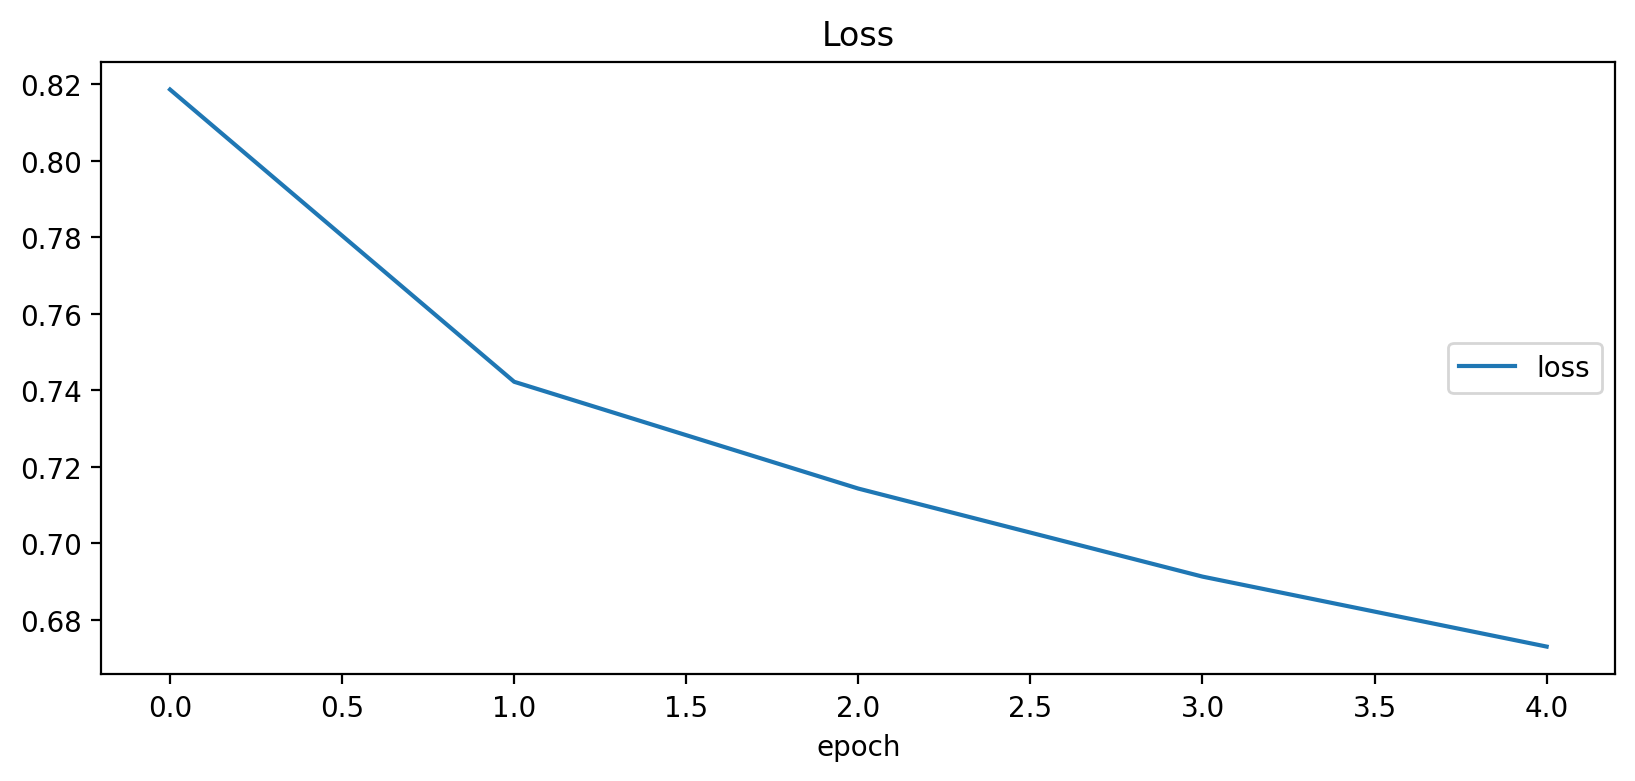

Loss
	loss             	 (min:    0.673, max:    0.819, cur:    0.673)


Version1(
  (embedding): Embedding(11631, 128)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (cnns): ModuleList(
    (0): Conv1d(128, 32, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 32, kernel_size=(5,), stride=(1,))
  )
  (lstm_layer): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (layer_norm_lstm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
# best results: LSTM dropout = 0.5, FC dropout -- 0.0, weight_decay 0.001
# warm up 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
scheduler = None
train(optimizer, criterion, scheduler, model, full_loader, None, epochs = 1, device = DEVICE)

# training
optimizer = Lion(model.parameters(), lr = 0.001, betas=(0.9, 0.98), weight_decay=0.001)
scheduler = None
train(optimizer, criterion, scheduler, model, full_loader, None, epochs = EPOCHS, device = DEVICE)

**Predicting for submission**

In [18]:
df_submission = pd.read_csv('/kaggle/input/reviewscores/preprocessed_submission.csv')

ds_submit = ReviewsSubmission(ds_full, df_submission, negative_column = 'negativeV1', 
                              positive_column = 'positiveV1', review_id = 'review_id')
submit_loader = get_loader_submit(ds_submit, batch_size = 256)

In [19]:
model.eval()

pred_list = []
id_list = []

with tqdm(total=len(submit_loader)) as prbar:
    for x, review_ids, lengths in submit_loader:
        score_pred = model(x.to(DEVICE), lengths)
        pred_list.extend(score_pred)
        id_list.extend(review_ids)
        prbar.update(1)

100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


In [36]:
pred_list = [float(x) for x in pred_list]
submission_neural = pd.DataFrame({'review_id': id_list, 'score': pred_list})
submission_neural.to_csv('submission_neural2.csv', index=False)